In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# !scp mygpu:TXL/transformer-xl/pytorch/test_res.csv ./test_res_retrieval.csv

In [4]:
# !scp gpu6:bulatov/TXL/_git/test_res.csv ./test_res_synthetic_results.csv

In [5]:
df_retrieval = pd.read_csv('test_res_retrieval.csv')
df = pd.read_csv('test_res_synthetic_results.csv')
# df = pd.concat((df, df_retrieval))

In [6]:
# df = pd.concat([df, df_retrieval])

In [7]:
df = df.dropna(subset=['test acc'])
df = df.drop('work_dir', axis=1)
df = df.drop_duplicates()

df_retrieval = df_retrieval.dropna(subset=['test acc'])
df_retrieval = df_retrieval.drop('work_dir', axis=1)
df_retrieval = df_retrieval.drop_duplicates()

In [8]:
df = df[(df.max_step > 450000) | (df.tgt_len >= 24)]
# df = df[~((df.tgt_len == 12) & (df.max_step == 700000))]
df = df[~((df.tgt_len == 24) & (df.max_step == 300000))]
df = df[~((df.tgt_len == 8) & (df.num_mem_tokens == 12))]
df = df[~((df.dataset == 'reverse') & (df.max_step == 900000))]

df_retrieval = df_retrieval[df_retrieval.mem_backprop_depth == 0]

In [9]:
# res_df = df

df = pd.concat((df, df_retrieval[df_retrieval.dataset == 'copy']))

In [10]:
df['mem_size'] = df.num_mem_tokens + df.mem_len
df_retrieval['mem_size'] = df_retrieval.num_mem_tokens + df_retrieval.mem_len

reverse = df[df.dataset == 'reverse']
copy = df[df.dataset == 'copy']
retrieval = df_retrieval[df_retrieval.dataset.apply(lambda x: 'retrieval' in x)]
# retrieval = df[df.dataset.apply(lambda x: 'retrieval' in x)]

retrieval = retrieval[(retrieval.lr == 0.0001) & (retrieval.tgt_len <= 10) & (retrieval.max_step != 250000)]

In [11]:
copy['n_chunks'] = (copy.tgt_len.max() / copy.tgt_len).astype(int)
reverse['n_chunks'] = (reverse.tgt_len.max() / reverse.tgt_len).astype(int)
retrieval['n_chunks'] = (10 / retrieval.tgt_len).apply(lambda x: np.ceil(x)).astype(int)

In [435]:
# df.to_csv('copy+reverse.csv', index=False)
# retrieval[retrieval.dataset == 'retrieval'].to_csv('retrieval.csv', index=False)

In [428]:
# mt.boxplot('test acc', by='num_mem_tokens', figsize=(10, 6), patch_artist=True, fontsize=16)

Text(0, 0.5, 'Accuracy')

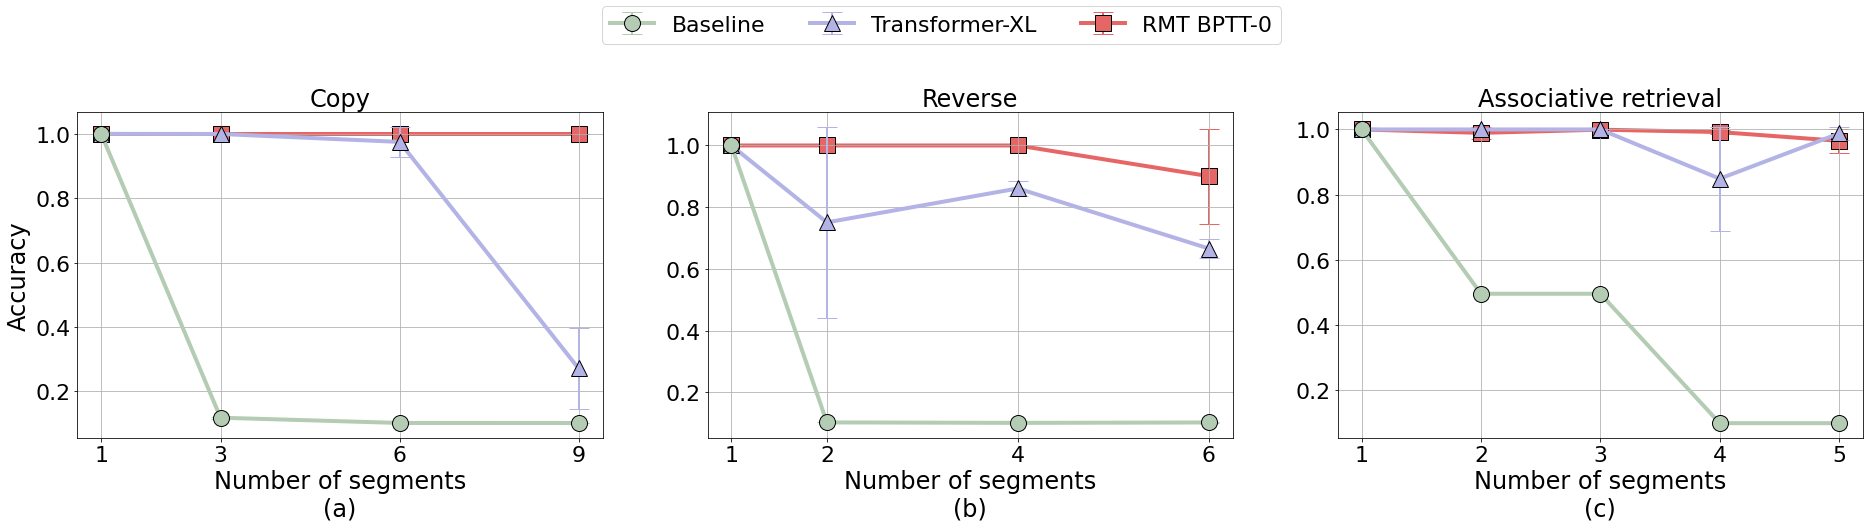

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(32, 6))
letters = ('a', 'b', 'c')
for i, (plot_df, name, letter) in enumerate(zip([copy, reverse, retrieval], ['Copy', 'Reverse', 'Associative retrieval'], letters)):

    fontdict = {'fontsize': 24}
    # fontsize = 28
    legsize = 22

    mt = plot_df[plot_df.num_mem_tokens > 0]
    xl = plot_df[plot_df.mem_len > 0]
    bl = plot_df[(plot_df.num_mem_tokens == 0) & (plot_df.mem_len == 0)]
    mt = pd.concat((mt, bl[bl.n_chunks == 1]))
    xl = pd.concat((xl, bl[bl.n_chunks == 1]))



    markers = ['s', '^', 'o'][::-1]
    dfs = [mt, xl, bl][::-1]
    zorders = [100, 50, 0]
    colors = [(0.7, 0.8, 0.7), (0.7, 0.7, 0.9), (0.9, 0.4, 0.4)]
    for z, d, m, c in zip(zorders, dfs, markers, colors): 
        # d = d[(d.mem_len != 6) & (d.num_mem_tokens != 6)]   
        d = d[(d.mem_size == d.tgt_len) | (d.mem_size == 0)]
        gd = d.groupby('n_chunks').agg({'test acc': tuple})
        gd['mean'] = d.groupby('n_chunks').mean()['test acc']
        gd['std'] = d.groupby('n_chunks').std()['test acc']
        gd = gd.reset_index()

        axs[i].errorbar(gd.n_chunks, gd['mean'], gd['std'], lw=4, color=c, marker=m, markeredgecolor='k', markersize=16, capsize=10, elinewidth=2, zorder=z)

    # axs[i].legend(['Baseline', 'Transformer-XL', 'RMT'], fontsize=legsize)

    # for z, d, m, c in zip(zorders, dfs, markers, colors):    
    #     d = d[(d.mem_len == 6) | (d.num_mem_tokens == 6)]
    #     gd = d.groupby('n_chunks').agg({'test acc': tuple})
    #     gd['mean'] = d.groupby('n_chunks').mean()['test acc']
    #     gd['std'] = d.groupby('n_chunks').std()['test acc']
    #     gd = gd.reset_index()

    #     axs[i].errorbar(gd.n_chunks, gd['mean'], gd['std'], lw=4, color=c, marker=m, markeredgecolor='k', markersize=8, capsize=10, elinewidth=2, zorder=z)

    axs[i].set_xlabel(f'Number of segments\n({letter})', fontdict=fontdict)
    
    ticks = np.unique(mt.n_chunks.astype(int))
    axs[i].set_xticks(ticks)
    axs[i].set_xticklabels(ticks)
    axs[i].set_title(name, fontdict=fontdict)
    axs[i].grid()
    axs[i].tick_params(labelsize=22)
    

axs[1].get_shared_x_axes().join(axs[0], axs[1])
fig.legend(['Baseline', 'Transformer-XL', 'RMT BPTT-0'], fontsize=legsize, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True)
axs[0].set_ylabel('Accuracy', fontdict=fontdict)
# plt.tight_layout()
# plt.savefig(f'../../Memory transformer/_figures_paper/res_combined.png', format='png')

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 12))
letters = ('a', 'b', 'c')
for i, (plot_df, name, letter) in enumerate(zip([copy, reverse], ['Copy', 'Reverse'], letters)):

    plot_df = plot_df[(plot_df.mem_size < plot_df.tgt_len) | (plot_df.mem_size == 0)]

    fontdict = {'fontsize': 24}
    # fontsize = 28
    legsize = 22

    mt = plot_df[plot_df.num_mem_tokens > 0]
    xl = plot_df[plot_df.mem_len > 0]
    bl = plot_df[(plot_df.num_mem_tokens == 0) & (plot_df.mem_len == 0)]
    mt = pd.concat((mt, bl[bl.n_chunks == 1]))
    xl = pd.concat((xl, bl[bl.n_chunks == 1]))



    markers = ['^', 's']
    dfs = [xl, mt]
    zorders = [50, 0]
    colors = [ (0.7, 0.7, 0.9), (0.9, 0.4, 0.4)]
    for z, d, m, c in zip(zorders, dfs, markers, colors): 
        gd = d.groupby('n_chunks').agg({'test acc': tuple})
        gd['mean'] = d.groupby('n_chunks').mean()['test acc']
        gd['std'] = d.groupby('n_chunks').std()['test acc']
        gd = gd.reset_index()

        axs[i].errorbar(gd.n_chunks, gd['mean'], gd['std'], lw=4, color=c, marker=m, markeredgecolor='k', markersize=16, capsize=10, elinewidth=2, zorder=z)

    # axs[i].legend(['Baseline', 'Transformer-XL', 'RMT'], fontsize=legsize)

    # for z, d, m, c in zip(zorders, dfs, markers, colors):    
    #     d = d[(d.mem_len == 6) | (d.num_mem_tokens == 6)]
    #     gd = d.groupby('n_chunks').agg({'test acc': tuple})
    #     gd['mean'] = d.groupby('n_chunks').mean()['test acc']
    #     gd['std'] = d.groupby('n_chunks').std()['test acc']
    #     gd = gd.reset_index()

    #     axs[i].errorbar(gd.n_chunks, gd['mean'], gd['std'], lw=4, color=c, marker=m, markeredgecolor='k', markersize=8, capsize=10, elinewidth=2, zorder=z)

    
    
    ticks = np.unique(mt.n_chunks.astype(int))
    axs[i].set_xticks(ticks)
    axs[i].set_xticklabels(ticks)
    axs[i].set_title(name, fontdict=fontdict)
    axs[i].grid()
    axs[i].tick_params(labelsize=22)
    axs[i].set_ylabel('Accuracy', fontdict=fontdict)
    

axs[0].set_xlabel('(a)', fontdict=fontdict)
axs[-1].set_xlabel('Number of segments\n(b)', fontdict=fontdict)
# axs[1].get_shared_y_axes().join(axs[0], axs[1])
fig.legend(['Transformer-XL', 'RMT BPTT-0'], fontsize=legsize, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True)

plt.tight_layout()
# plt.savefig(f'../../Memory transformer/_figures_paper/res_combined.png', format='png')

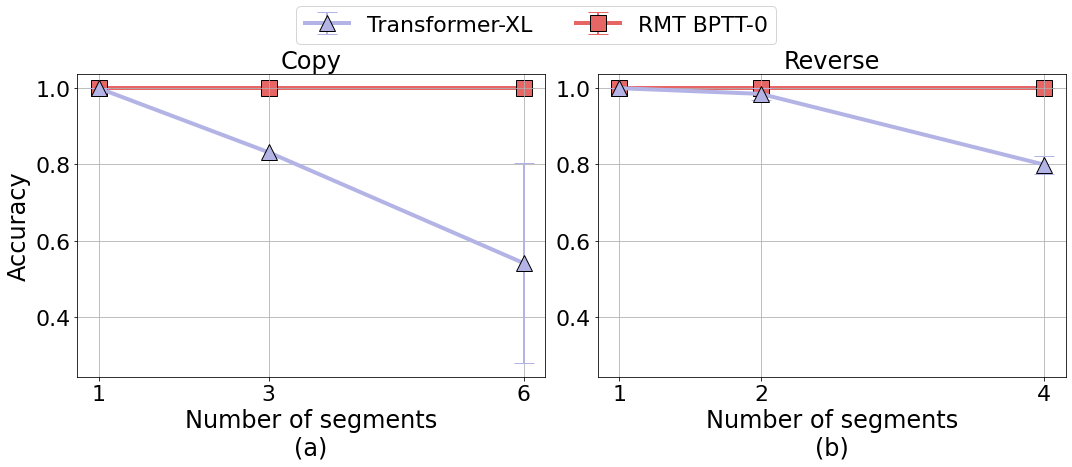

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
letters = ('a', 'b', 'c')
axes = []
for i, (plot_df, name, letter) in enumerate(zip([copy, reverse], ['Copy', 'Reverse'], letters)):

    plot_df = plot_df[(plot_df.mem_size < plot_df.tgt_len) | (plot_df.mem_size == 0)]

    fontdict = {'fontsize': 24}
    # fontsize = 28
    legsize = 22

    mt = plot_df[plot_df.num_mem_tokens > 0]
    xl = plot_df[plot_df.mem_len > 0]
    bl = plot_df[(plot_df.num_mem_tokens == 0) & (plot_df.mem_len == 0)]
    mt = pd.concat((mt, bl[bl.n_chunks == 1]))
    xl = pd.concat((xl, bl[bl.n_chunks == 1]))



    markers = ['^', 's']
    dfs = [xl, mt]
    zorders = [50, 0]
    colors = [ (0.7, 0.7, 0.9), (0.9, 0.4, 0.4)]
    for z, d, m, c in zip(zorders, dfs, markers, colors): 
        gd = d.groupby('n_chunks').agg({'test acc': tuple})
        gd['mean'] = d.groupby('n_chunks').mean()['test acc']
        gd['std'] = d.groupby('n_chunks').std()['test acc']
        gd = gd.reset_index()

        axs[i].errorbar(gd.n_chunks, gd['mean'], gd['std'], lw=4, color=c, marker=m, markeredgecolor='k', markersize=16, capsize=10, elinewidth=2, zorder=z)
        

    # axs[i].legend(['Baseline', 'Transformer-XL', 'RMT'], fontsize=legsize)

    # for z, d, m, c in zip(zorders, dfs, markers, colors):    
    #     d = d[(d.mem_len == 6) | (d.num_mem_tokens == 6)]
    #     gd = d.groupby('n_chunks').agg({'test acc': tuple})
    #     gd['mean'] = d.groupby('n_chunks').mean()['test acc']
    #     gd['std'] = d.groupby('n_chunks').std()['test acc']
    #     gd = gd.reset_index()

    #     axs[i].errorbar(gd.n_chunks, gd['mean'], gd['std'], lw=4, color=c, marker=m, markeredgecolor='k', markersize=8, capsize=10, elinewidth=2, zorder=z)

    
    
    ticks = np.unique(mt.n_chunks.astype(int))
    axs[i].set_xticks(ticks)
    axs[i].set_xticklabels(ticks)
    axs[i].set_title(name, fontdict=fontdict)
    axs[i].grid()
    axs[i].tick_params(labelsize=22)
    
    

    # axs[0].set_xlabel('(a)', fontdict=fontdict)
    # axs[-1].set_xlabel('Number of segments\n(b)', fontdict=fontdict)
    axs[i].set_xlabel(f'Number of segments\n({letter})', fontdict=fontdict)
# axs[1].get_shared_y_axes().join(axs[0], axs[1])
axs[1].sharey(axs[0])
axs[0].set_ylabel('Accuracy', fontdict=fontdict)

fig.legend(['Transformer-XL', 'RMT BPTT-0'], fontsize=legsize, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, fancybox=True)

plt.tight_layout()
# plt.savefig(f'../../Memory transformer/_figures_paper/res_combined.png', format='png')

In [ ]:
# plot_df = copy

# fontdict = {'fontsize': 18}

# mt = plot_df[plot_df.num_mem_tokens > 0]
# xl = plot_df[plot_df.mem_len > 0]
# bl = plot_df[(plot_df.num_mem_tokens == 0) & (plot_df.mem_len == 0)]
# mt = pd.concat((mt, bl[bl.n_chunks == 1]))
# xl = pd.concat((xl, bl[bl.n_chunks == 1]))


# fig = plt.figure(figsize=(8, 5))

# markers = ['s', '^', 'o'][::-1]
# dfs = [mt, xl, bl][::-1]
# zorders = [100, 50, 0]
# colors = [(0.9, 0.9, 1), (0.75, 0.4, 0.4), (0.7, 0.7, 1)]
# for z, d, m, c in zip(zorders, dfs, markers, colors):
#     gd = d.groupby('n_chunks').agg({'test acc': tuple})
#     gd['mean'] = d.groupby('n_chunks').mean()['test acc']
#     gd['std'] = d.groupby('n_chunks').std()['test acc']
#     gd = gd.reset_index()

#     plt.errorbar(gd.n_chunks, gd['mean'], gd['std'], lw=4, color=c, marker=m, markeredgecolor='k', markersize=12, capsize=10, elinewidth=2, zorder=z)

# plt.legend(['Baseline', 'Transformer-XL', 'RMT'], fontsize=16)

# plt.xlabel('Number of segments', fontdict=fontdict)
# plt.ylabel('Accuracy', fontdict=fontdict)
# ticks = np.unique(mt.n_chunks.astype(int))
# plt.xticks(ticks, labels=ticks)
# plt.grid()
# plt.savefig('../../Memory transformer/_figures_paper/res_copy.png', format='png')
# plt.show()


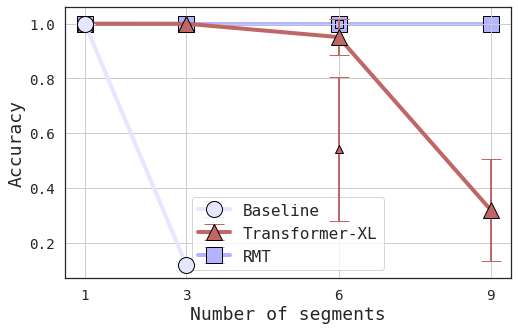

In [256]:
plot_df = copy

fontdict = {'fontsize': 18}

mt = plot_df[plot_df.num_mem_tokens > 0]
xl = plot_df[plot_df.mem_len > 0]
bl = plot_df[(plot_df.num_mem_tokens == 0) & (plot_df.mem_len == 0)]
mt = pd.concat((mt, bl[bl.n_chunks == 1]))
xl = pd.concat((xl, bl[bl.n_chunks == 1]))


fig = plt.figure(figsize=(8, 5))

markers = ['s', '^', 'o'][::-1]
dfs = [mt, xl, bl][::-1]
zorders = [100, 50, 0]
colors = [(0.9, 0.9, 1), (0.75, 0.4, 0.4), (0.7, 0.7, 1)]
for z, d, m, c in zip(zorders, dfs, markers, colors): 
    d = d[(d.mem_len != 6) & (d.num_mem_tokens != 6)]   
    gd = d.groupby('n_chunks').agg({'test acc': tuple})
    gd['mean'] = d.groupby('n_chunks').mean()['test acc']
    gd['std'] = d.groupby('n_chunks').std()['test acc']
    gd = gd.reset_index()

    plt.errorbar(gd.n_chunks, gd['mean'], gd['std'], lw=4, color=c, marker=m, markeredgecolor='k', markersize=16, capsize=10, elinewidth=2, zorder=z)

plt.legend(['Baseline', 'Transformer-XL', 'RMT'], fontsize=16)

for z, d, m, c in zip(zorders, dfs, markers, colors):    
    d = d[(d.mem_len == 6) | (d.num_mem_tokens == 6)]
    gd = d.groupby('n_chunks').agg({'test acc': tuple})
    gd['mean'] = d.groupby('n_chunks').mean()['test acc']
    gd['std'] = d.groupby('n_chunks').std()['test acc']
    gd = gd.reset_index()

    plt.errorbar(gd.n_chunks, gd['mean'], gd['std'], lw=4, color=c, marker=m, markeredgecolor='k', markersize=8, capsize=10, elinewidth=2, zorder=z)


plt.xlabel('Number of segments', fontdict=fontdict)
plt.ylabel('Accuracy', fontdict=fontdict)
ticks = np.unique(mt.n_chunks.astype(int))
plt.xticks(ticks, labels=ticks)
plt.grid()
plt.savefig('../../Memory transformer/_figures_paper/res_copy.png', format='png')
plt.show()


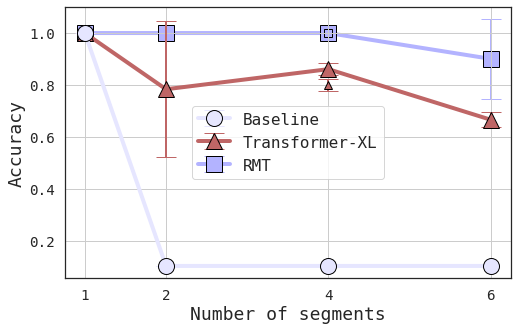

In [257]:
plot_df = reverse

fontdict = {'fontsize': 18}

mt = plot_df[plot_df.num_mem_tokens > 0]
xl = plot_df[plot_df.mem_len > 0]
bl = plot_df[(plot_df.num_mem_tokens == 0) & (plot_df.mem_len == 0)]
mt = pd.concat((mt, bl[bl.n_chunks == 1]))
xl = pd.concat((xl, bl[bl.n_chunks == 1]))


fig = plt.figure(figsize=(8, 5))

markers = ['s', '^', 'o'][::-1]
dfs = [mt, xl, bl][::-1]
zorders = [100, 50, 0]
colors = [(0.9, 0.9, 1), (0.75, 0.4, 0.4), (0.7, 0.7, 1)]
for z, d, m, c in zip(zorders, dfs, markers, colors): 
    d = d[(d.mem_len != 6) & (d.num_mem_tokens != 6)]   
    gd = d.groupby('n_chunks').agg({'test acc': tuple})
    gd['mean'] = d.groupby('n_chunks').mean()['test acc']
    gd['std'] = d.groupby('n_chunks').std()['test acc']
    gd = gd.reset_index()

    plt.errorbar(gd.n_chunks, gd['mean'], gd['std'], lw=4, color=c, marker=m, markeredgecolor='k', markersize=16, capsize=10, elinewidth=2, zorder=z)

plt.legend(['Baseline', 'Transformer-XL', 'RMT'], fontsize=16)

for z, d, m, c in zip(zorders, dfs, markers, colors):    
    d = d[(d.mem_len == 6) | (d.num_mem_tokens == 6)]
    gd = d.groupby('n_chunks').agg({'test acc': tuple})
    gd['mean'] = d.groupby('n_chunks').mean()['test acc']
    gd['std'] = d.groupby('n_chunks').std()['test acc']
    gd = gd.reset_index()

    plt.errorbar(gd.n_chunks, gd['mean'], gd['std'], lw=4, color=c, marker=m, markeredgecolor='k', markersize=8, capsize=10, elinewidth=2, zorder=z)

plt.xlabel('Number of segments', fontdict=fontdict)
plt.ylabel('Accuracy', fontdict=fontdict)
ticks = np.unique(mt.n_chunks.astype(int))
plt.xticks(ticks, labels=ticks)
plt.grid()
plt.savefig('../../Memory transformer/_figures_paper/res_reverse.png', format='png')
plt.show()

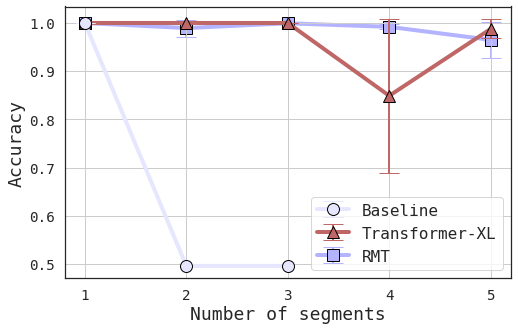

In [250]:
plot_df = retrieval

fontdict = {'fontsize': 18}

mt = plot_df[plot_df.num_mem_tokens > 0]
xl = plot_df[plot_df.mem_len > 0]
bl = plot_df[(plot_df.num_mem_tokens == 0) & (plot_df.mem_len == 0)]
mt = pd.concat((mt, bl[bl.n_chunks == 1]))
xl = pd.concat((xl, bl[bl.n_chunks == 1]))


fig = plt.figure(figsize=(8, 5))

markers = ['s', '^', 'o'][::-1]
dfs = [mt, xl, bl][::-1]
zorders = [100, 50, 0]
colors = [(0.9, 0.9, 1), (0.75, 0.4, 0.4), (0.7, 0.7, 1)]
for z, d, m, c in zip(zorders, dfs, markers, colors):
    gd = d.groupby('n_chunks').agg({'test acc': tuple})
    gd['mean'] = d.groupby('n_chunks').mean()['test acc']
    gd['std'] = d.groupby('n_chunks').std()['test acc']
    gd = gd.reset_index()
    plt.errorbar(gd.n_chunks, gd['mean'], gd['std'], lw=4, color=c, marker=m, markeredgecolor='k', markersize=12, capsize=10, elinewidth=2, zorder=z)

plt.legend(['Baseline', 'Transformer-XL', 'RMT'], fontsize=16)

plt.xlabel('Number of segments', fontdict=fontdict)
plt.ylabel('Accuracy', fontdict=fontdict)
ticks = np.unique(mt.n_chunks.astype(int))
plt.xticks(ticks, labels=ticks)
plt.grid()
plt.savefig('../../Memory transformer/_figures_paper/res_retrieval.png', format='png')
plt.show()

## scatter

In [12]:
# gb_cols = ['dataset', 'tgt_len', 'lr', 'max_step',  'num_mem_tokens', 'mem_len', 'mem_backprop_depth']#, 'seed']
# df_ = retrieval
# gb = df_.dropna(subset=['test acc']).groupby(gb_cols).agg({'test acc': tuple})
# gb['mean acc'] = df_.groupby(gb_cols).mean()['test acc']
# gb

In [14]:
# gb_cols = ['dataset', 'tgt_len', 'lr', 'max_step',  'num_mem_tokens', 'mem_len', 'mem_backprop_depth']#, 'seed']
# df_ = copy
# gb = df_.dropna(subset=['test acc']).groupby(gb_cols).agg({'test acc': tuple})
# gb['mean acc'] = df_.groupby(gb_cols).mean()['test acc']
# gb

In [15]:
import seaborn as sns

sns.set_theme(style='white', palette='BuPu', font_scale=1.3, font='monospace')
# import matplotlib.lines as mlines
import matplotlib.patches as mpatches
# import matplotlib.pyplot as plt


In [16]:
# plot_df = copy
# plot_df['n_chunks'] = (plot_df.tgt_len.max() / plot_df.tgt_len).astype(int)
# plot_df = plot_df.sort_values('n_chunks')

# mt = plot_df[plot_df.num_mem_tokens > 0]
# xl = plot_df[plot_df.mem_len > 0]
# bl = plot_df[(plot_df.num_mem_tokens == 0) & (plot_df.mem_len == 0)]

# plt.scatter(mt.tgt_len, mt['test acc'], edgecolor='grey', c='b', s=60)
# plt.scatter(xl.tgt_len, xl['test acc'], edgecolor='grey', c='r', s=60, zorder=0)
# plt.scatter(bl.tgt_len, bl['test acc'], edgecolor='grey', c='w', s=60, zorder=0)
# plt.legend(['MT', 'XL', 'Baseline'])

In [17]:
# plot_df = copy
# plot_df['n_chunks'] = (plot_df.tgt_len.max() / plot_df.tgt_len).astype(int)
# plot_df = plot_df.sort_values('n_chunks')
# plot_df

0.06151879596515051

In [ ]:
sns.stripplot()

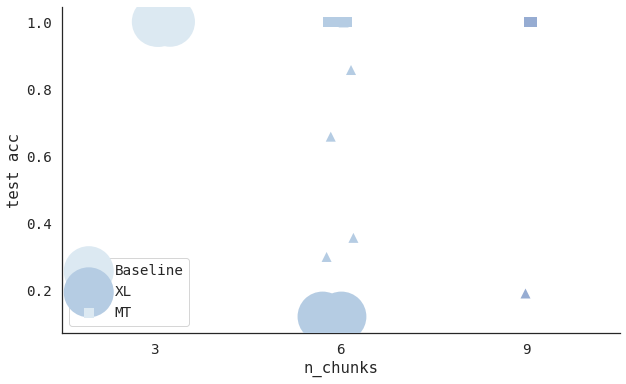

In [79]:
# plot_df = copy
# plot_df['n_chunks'] = (plot_df.tgt_len.max() / plot_df.tgt_len).astype(int)
# plot_df = plot_df.sort_values('n_chunks')

# mt = plot_df[plot_df.num_mem_tokens > 0]
# xl = plot_df[plot_df.mem_len > 0]
# bl = plot_df[(plot_df.num_mem_tokens == 0) & (plot_df.mem_len == 0)]


# plt.figure(figsize=(10, 6))
# # xs = mt.n_chunks + np.random.normal(0, 0.2, mt.shape[0])
# # plt.scatter(xs, mt['test acc'], edgecolor='grey', c='b', s=60, marker='s')

# # xs = xl.n_chunks + np.random.normal(0, 0.2, xl.shape[0])
# # plt.scatter(xl.n_chunks, xl['test acc'], edgecolor='grey', c='r', s=60, marker='^', zorder=0)
# # plt.scatter(bl.n_chunks, bl['test acc'], edgecolor='grey', c='w', s=60, marker='o', zorder=10)

# sns.stripplot(x=bl.n_chunks, y=bl['test acc'], edgecolor='grey', s=50, marker='o')
# sns.stripplot(x=mt.n_chunks, y=mt['test acc'], edgecolor='grey', s=10, marker='s')
# sns.stripplot(x=xl.n_chunks, y=xl['test acc'], edgecolor='grey', s=10, marker='^')

# # sns.scatterplot(bl.n_chunks, bl['test acc'], edgecolor='grey', s=50, marker='o', zorder=0, x_jitter=True)
# # sns.scatterplot(xl.n_chunks, xl['test acc'], edgecolor='grey', s=50, marker='^', zorder=0, x_jitter=True)
# # sns.scatterplot(mt.n_chunks, mt['test acc'], edgecolor='grey', s=50, marker='s', )

# plt.legend(['Baseline', 'XL', 'MT'])
# sns.despine()

# # MT_marker = mpatches.Patch([], [], color='blue', marker='s',
# #                           markersize=15, label='MT')
# # XL_marker = mlines.Line2D([], [], color='r', marker='^',
# #                           markersize=15, label='XL')                          
# # BL_marker = mlines.Line2D([], [], color='w', marker='o',
# #                           markersize=15, label='Baseline')

# # plt.legend(handles=[MT_marker, XL_marker, BL_marker])
# # plt.legend([MT_marker, XL_marker, BL_marker])

# plt.show()

## barplots

In [141]:
# plot_df = copy
# plot_df['n_chunks'] = (plot_df.tgt_len.max() / plot_df.tgt_len).astype(int)
# plot_df = plot_df.sort_values('n_chunks')

# mt = plot_df[plot_df.num_mem_tokens > 0]
# xl = plot_df[plot_df.mem_len > 0]
# bl = plot_df[(plot_df.num_mem_tokens == 0) & (plot_df.mem_len == 0)]

# plt.bar(mt.n_chunks, mt['test acc'], edgecolor='grey', color='b')
# plt.bar(xl.n_chunks, xl['test acc'], edgecolor='grey', color='r')
# plt.bar(bl.n_chunks, bl['test acc'], edgecolor='grey', color='w')
# plt.legend(['MT', 'XL', 'Baseline'])

In [277]:
# df = reverse
# n_chunks = np.unique(df.n_chunks)
# plot_df = pd.DataFrame(index = n_chunks)

# plot_df['baseline'] = [(df[(df.num_mem_tokens == 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc']).values for i in n_chunks]
# plot_df['MT'] = [(df[(df.num_mem_tokens > 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc']).values for i in n_chunks]
# plot_df['TXL'] = [(df[(df.num_mem_tokens == 0) & (df.mem_len > 0) & (df.n_chunks == i)]['test acc']).values for i in n_chunks]
# plot_df.loc[1] = [plot_df.baseline.iloc[0]] * 3


# plt.figure(figsize=(8, 4))

# for i, row in plot_df.iterrows():
#     print(row.baseline)
#     if len(row.baseline) > 0:
#         # plt.axvline(i-0.5, ymin=min(row.baseline)-0.1, ymax=max(row.baseline), lw=50)
#         plt.axvspan(xmin=i-0.75, xmax=i-0.25, ymin=min(row.baseline)-0.5, ymax=max(row.baseline), lw=50)


# plt.xlabel('Number of segments')
# plt.xticks(rotation=0)
# plt.yticks([0, 1])
# plt.ylabel('accuracy')
# plt.show()

In [238]:
# df = reverse
# n_chunks = np.unique(df.n_chunks)
# plot_df = pd.DataFrame(index = n_chunks)

# plt.figure(figsize=(8, 4))

# plot_df['baseline'] = [df[(df.num_mem_tokens == 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].min() for i in n_chunks]
# plot_df['MT'] = [df[(df.num_mem_tokens > 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].min() for i in n_chunks]
# plot_df['TXL'] = [df[(df.num_mem_tokens == 0) & (df.mem_len > 0) & (df.n_chunks == i)]['test acc'].min() for i in n_chunks]
# plot_df.loc[1] = 1

# # plot_df.reset_index().plot(x='index', kind='bar', figsize=(12, 8), cmap='BuPu', edgecolor='grey', width=0.7, color=[(0.8, 0.1, 0.1), (0.6, 0.6, 1), 'w'])
# width=0.4
# xs = np.arange(plot_df.shape[0])
# plt.bar(xs-width, plot_df.baseline.values, width=width)
# plt.bar(xs, plot_df.MT.values, width=width)
# plt.bar(xs+width, plot_df.TXL.values, width=width)

# plt.xticks([str(i) for i in np.array(plot_df.index)])

# # plot_df['baseline'] = [df[(df.num_mem_tokens == 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].mean() for i in n_chunks]
# # plot_df['MT'] = [df[(df.num_mem_tokens > 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].mean() for i in n_chunks]
# # plot_df['TXL'] = [df[(df.num_mem_tokens == 0) & (df.mem_len > 0) & (df.n_chunks == i)]['test acc'].mean() for i in n_chunks]
# # plot_df.loc[1] = 1

# # plot_df.reset_index().plot(x='index', kind='bar', figsize=(12, 8), cmap='BuPu', edgecolor='grey', width=0.7, color=[(0.8, 0.1, 0.1), (0.6, 0.6, 1), 'w'])


# plt.xlabel('Number of segments')
# # plt.xticks(rotation=0)
# plt.yticks([0, 1])
# plt.ylabel('accuracy')
# plt.show()

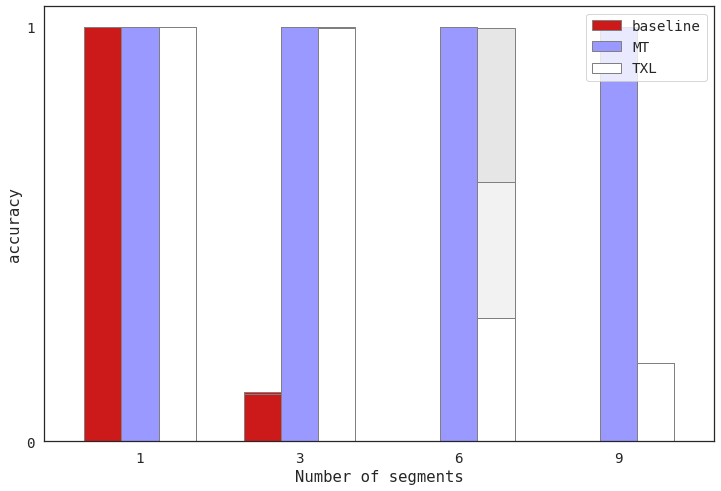

In [255]:
df = copy
n_chunks = np.unique(df.n_chunks)
plot_df = pd.DataFrame(index = n_chunks)

plot_df['baseline'] = [df[(df.num_mem_tokens == 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].max() for i in n_chunks]
plot_df['MT'] = [df[(df.num_mem_tokens > 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].max() for i in n_chunks]
plot_df['TXL'] = [df[(df.num_mem_tokens == 0) & (df.mem_len > 0) & (df.n_chunks == i)]['test acc'].max() for i in n_chunks]
plot_df.loc[1] = 1

ax = plot_df.reset_index().plot(x='index', kind='bar', figsize=(12, 8), cmap='BuPu', edgecolor='grey', width=0.7, color=[(0.8, 0.1, 0.1), (0.4, 0.4, 1), (0.9, 0.9, 0.9)], legend=False)

plot_df['baseline'] = [df# plot_df = copy[(df.num_mem_tokens == 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].mean() for i in n_chunks]
plot_df['MT'] = [df[(df.num_mem_tokens > 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].mean() for i in n_chunks]
plot_df['TXL'] = [df[(df.num_mem_tokens == 0) & (df.mem_len > 0) & (df.n_chunks == i)]['test acc'].mean() for i in n_chunks]

plot_df.reset_index().plot(x='index', kind='bar', ax=ax, cmap='BuPu', edgecolor='grey', width=0.7, color=[(0.8, 0.1, 0.1), (0.5, 0.5, 1), (0.95, 0.95, 0.95)], legend=False)

plot_df['baseline'] = [df[(df.num_mem_tokens == 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].min() for i in n_chunks]
plot_df['MT'] = [df[(df.num_mem_tokens > 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].min() for i in n_chunks]
plot_df['TXL'] = [df[(df.num_mem_tokens == 0) & (df.mem_len > 0) & (df.n_chunks == i)]['test acc'].min() for i in n_chunks]
plot_df.loc[1] = 1

plot_df.reset_index().plot(x='index', kind='bar', ax=ax, cmap='BuPu', edgecolor='grey', width=0.7, color=[(0.8, 0.1, 0.1), (0.6, 0.6, 1), 'w'], legend=True)


plt.xlabel('Number of segments')
plt.xticks(rotation=0)
plt.yticks([0, 1])
plt.ylabel('accuracy')

plt.show()

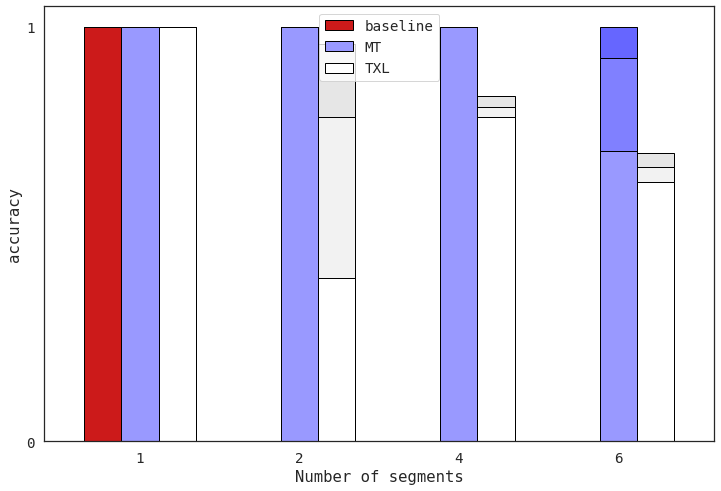

In [254]:
df = reverse
n_chunks = np.unique(df.n_chunks)
plot_df = pd.DataFrame(index = n_chunks)

plot_df['baseline'] = [df[(df.num_mem_tokens == 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].max() for i in n_chunks]
plot_df['MT'] = [df[(df.num_mem_tokens > 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].max() for i in n_chunks]
plot_df['TXL'] = [df[(df.num_mem_tokens == 0) & (df.mem_len > 0) & (df.n_chunks == i)]['test acc'].max() for i in n_chunks]
plot_df.loc[1] = 1

ax = plot_df.reset_index().plot(x='index', kind='bar', figsize=(12, 8), cmap='BuPu', edgecolor='k', width=0.7, color=[(0.8, 0.1, 0.1), (0.4, 0.4, 1), (0.9, 0.9, 0.9)], legend=False)

plot_df['baseline'] = [df[(df.num_mem_tokens == 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].mean() for i in n_chunks]
plot_df['MT'] = [df[(df.num_mem_tokens > 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].mean() for i in n_chunks]
plot_df['TXL'] = [df[(df.num_mem_tokens == 0) & (df.mem_len > 0) & (df.n_chunks == i)]['test acc'].mean() for i in n_chunks]

plot_df.reset_index().plot(x='index', kind='bar', ax=ax, cmap='BuPu', edgecolor='k', width=0.7, color=[(0.8, 0.1, 0.1), (0.5, 0.5, 1), (0.95, 0.95, 0.95)], legend=False)

plot_df['baseline'] = [df[(df.num_mem_tokens == 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].min() for i in n_chunks]
plot_df['MT'] = [df[(df.num_mem_tokens > 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].min() for i in n_chunks]
plot_df['TXL'] = [df[(df.num_mem_tokens == 0) & (df.mem_len > 0) & (df.n_chunks == i)]['test acc'].min() for i in n_chunks]
plot_df.loc[1] = 1

plot_df.reset_index().plot(x='index', kind='bar', ax=ax, cmap='BuPu', edgecolor='k', width=0.7, color=[(0.8, 0.1, 0.1), (0.6, 0.6, 1), 'w'], legend=True)


plt.xlabel('Number of segments')
plt.xticks(rotation=0)
plt.yticks([0, 1])
plt.ylabel('accuracy')

plt.show()

/home/ayd98/anaconda3/envs/cudaenv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:244: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
/home/ayd98/anaconda3/envs/cudaenv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/style.py:123: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


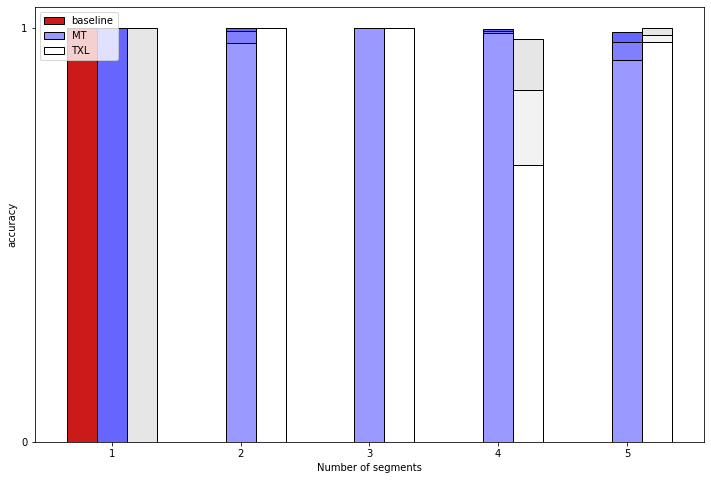

In [33]:
df = retrieval
n_chunks = [1, 2, 3, 4, 5]
plot_df = pd.DataFrame(index = n_chunks)

plot_df['baseline'] = [df[(df.num_mem_tokens == 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].max() for i in n_chunks]
plot_df['MT'] = [df[(df.num_mem_tokens > 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].max() for i in n_chunks]
plot_df['TXL'] = [df[(df.num_mem_tokens == 0) & (df.mem_len > 0) & (df.n_chunks == i)]['test acc'].max() for i in n_chunks]
plot_df = plot_df.sort_index()
plot_df.loc[1] = 1
ax = plot_df.reset_index().plot(x='index', kind='bar', figsize=(12, 8), cmap='BuPu', edgecolor='k', width=0.7, color=[(0.8, 0.1, 0.1), (0.4, 0.4, 1), (0.9, 0.9, 0.9)], legend=False)

plot_df['baseline'] = [df[(df.num_mem_tokens == 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].mean() for i in n_chunks]
plot_df['MT'] = [df[(df.num_mem_tokens > 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].mean() for i in n_chunks]
plot_df['TXL'] = [df[(df.num_mem_tokens == 0) & (df.mem_len > 0) & (df.n_chunks == i)]['test acc'].mean() for i in n_chunks]
plot_df = plot_df.sort_index()

plot_df.reset_index().plot(x='index', kind='bar', ax=ax, cmap='BuPu', edgecolor='k', width=0.7, color=[(0.8, 0.1, 0.1), (0.5, 0.5, 1), (0.95, 0.95, 0.95)], legend=False)

plot_df['baseline'] = [df[(df.num_mem_tokens == 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].min() for i in n_chunks]
plot_df['MT'] = [df[(df.num_mem_tokens > 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].min() for i in n_chunks]
plot_df['TXL'] = [df[(df.num_mem_tokens == 0) & (df.mem_len > 0) & (df.n_chunks == i)]['test acc'].min() for i in n_chunks]
plot_df = plot_df.sort_index()


plot_df.reset_index().plot(x='index', kind='bar', ax=ax, cmap='BuPu', edgecolor='k', width=0.7, color=[(0.8, 0.1, 0.1), (0.6, 0.6, 1), 'w'], legend=True)


plt.xlabel('Number of segments')
plt.xticks(rotation=0)
plt.yticks([0, 1])
plt.ylabel('accuracy')

plt.show()

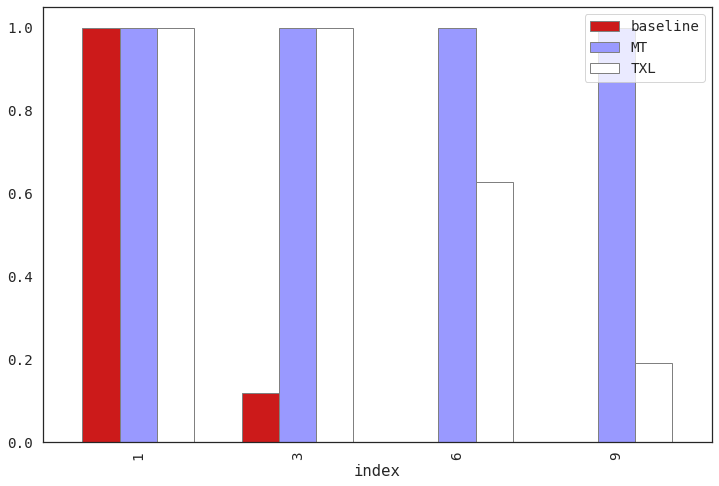

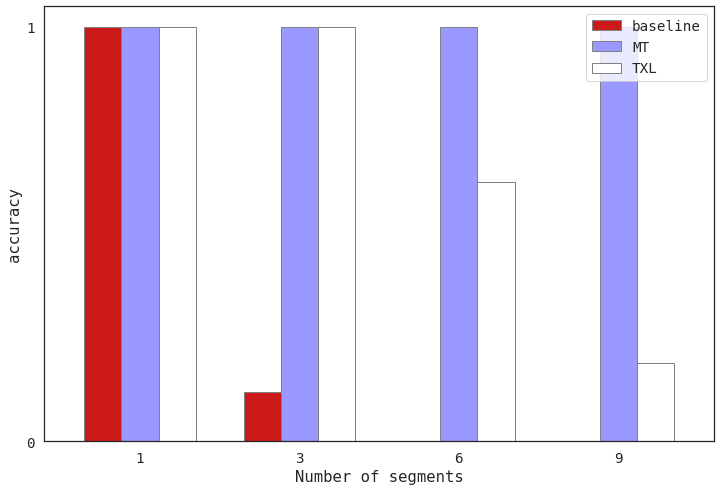

In [237]:
df = copy
n_chunks = np.unique(df.n_chunks)
plot_df = pd.DataFrame(index = n_chunks)

plot_df['baseline'] = [df[(df.num_mem_tokens == 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].mean() for i in n_chunks]
plot_df['MT'] = [df[(df.num_mem_tokens > 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].mean() for i in n_chunks]
plot_df['TXL'] = [df[(df.num_mem_tokens == 0) & (df.mem_len > 0) & (df.n_chunks == i)]['test acc'].mean() for i in n_chunks]
plot_df.loc[1] = 1


# plt.figure(figsize=(8, 4))
ax = plot_df.reset_index().plot(x='index', kind='bar', figsize=(12, 8), cmap='BuPu', edgecolor='grey', width=0.7, color=[(0.8, 0.1, 0.1), (0.6, 0.6, 1), 'w'])
plot_df.reset_index().plot(x='index', kind='bar', figsize=(12, 8), cmap='BuPu', edgecolor='grey', width=0.7, color=[(0.8, 0.1, 0.1), (0.6, 0.6, 1), 'w'])
plt.xlabel('Number of segments')
plt.xticks(rotation=0)
plt.yticks([0, 1])
plt.ylabel('accuracy')

plt.show()

In [161]:
retrieval.n_chunks

17     1
18     1
19     1
40     1
41     1
42     1
73     1
74     1
75     1
98     1
99     1
100    1
102    1
103    1
104    1
150    2
151    2
153    2
171    2
172    2
396    1
397    1
398    1
399    1
Name: n_chunks, dtype: int64

<Figure size 576x288 with 0 Axes>

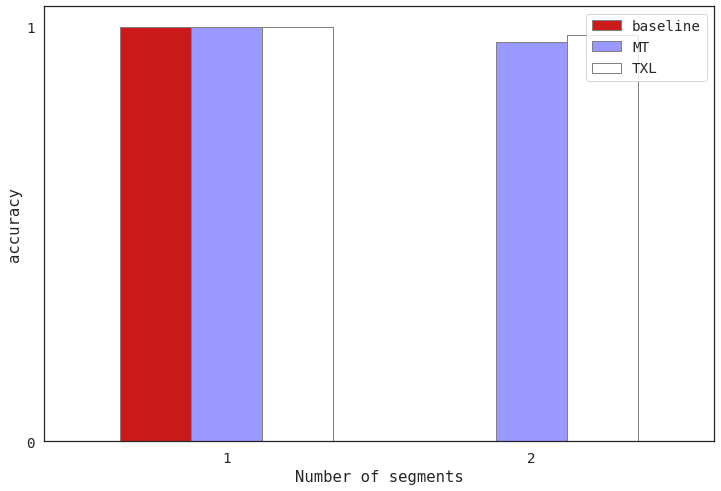

In [160]:
df = retrieval
n_chunks = np.unique(df.n_chunks)
plot_df = pd.DataFrame(index = n_chunks)

plot_df['baseline'] = [df[(df.num_mem_tokens == 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].mean() for i in n_chunks]
plot_df['MT'] = [df[(df.num_mem_tokens > 0) & (df.mem_len == 0) & (df.n_chunks == i)]['test acc'].mean() for i in n_chunks]
plot_df['TXL'] = [df[(df.num_mem_tokens == 0) & (df.mem_len > 0) & (df.n_chunks == i)]['test acc'].mean() for i in n_chunks]
plot_df.loc[1] = 1


plt.figure(figsize=(8, 4))
plot_df.reset_index().plot(x='index', kind='bar', figsize=(12, 8), cmap='BuPu', edgecolor='grey', width=0.7, color=[(0.8, 0.1, 0.1), (0.6, 0.6, 1), 'w'])
plt.xlabel('Number of segments')
plt.xticks(rotation=0)
plt.yticks([0, 1])
plt.ylabel('accuracy')
plt.show()

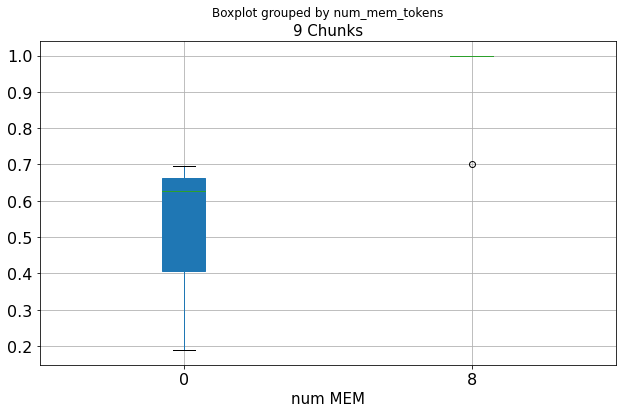

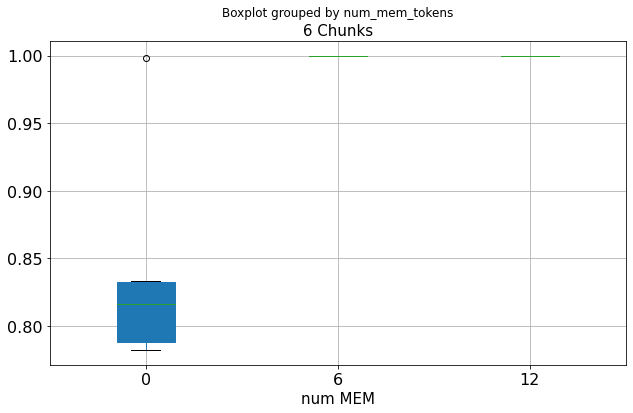

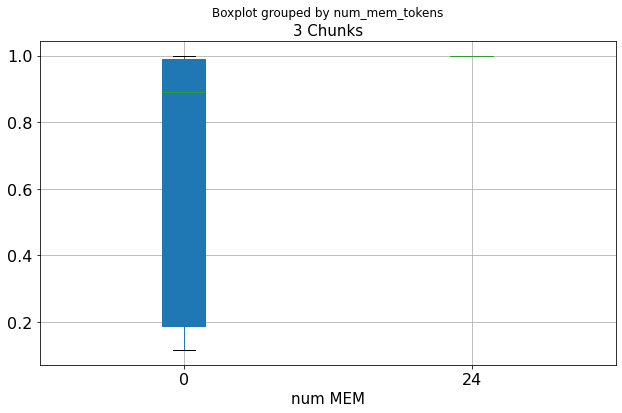

In [64]:
for tgt_len in np.unique(plot_df.tgt_len):
    n_chunks = int(np.ceil(df.tgt_len.max() / tgt_len))
    
    slice = df[df.tgt_len == tgt_len]
    slice.boxplot('test acc', by='num_mem_tokens', figsize=(10, 6), patch_artist=True, fontsize=16)
    plt.xlabel('num MEM', fontdict={'size': 15})
    plt.title(f'{n_chunks} Chunks', fontdict={'size': 15})

In [50]:
df_ = reverse
gb_cols = ['dataset', 'tgt_len', 'max_step',  'num_mem_tokens', 'mem_len', 'mem_backprop_depth']#, 'seed']
gb = df_.dropna(subset=['test acc']).groupby(gb_cols).agg({'test acc': tuple})
gb['mean acc'] = df_.groupby(gb_cols).mean()['test acc']
gb['med acc'] = df_.groupby(gb_cols).median()['test acc']
gb['med acc'] = df_.groupby(gb_cols).median()['test acc']
gb

test acc  \
dataset tgt_len max_step num_mem_tokens mem_len mem_backprop_depth                                 
reverse 8       700000   0              8       0                                 (0.696, 0.627)   
                         8              0       0                         (0.701, 1.0, 1.0, 1.0)   
        12      850000   0              6       0                     (0.832, 0.8, 0.784, 0.782)   
                                        12      0                                       (0.833,)   
                         6              0       0                                (1.0, 1.0, 1.0)   
                         12             0       0                                (1.0, 1.0, 1.0)   
        24      400000   0              24      0                   (0.959, 0.394, 0.881, 0.899)   
                         24             0       0                           (1.0, 1.0, 1.0, 1.0)   
        48      250000   0              0       0                                (1.0, 1.0, 1.0)   

                                                                    mean acc  \
dataset tgt_len max_step num_mem_tokens mem_len mem_backprop_depth             
reverse 8       700000   0              8       0                    0.66150   
                         8              0       0                    0.92525   
        12      850000   0              6       0                    0.79950   
                                        12      0                    0.83300   
                         6              0       0                    1.00000   
                         12             0       0                    1.00000   
        24      400000   0              24      0                    0.78325   
                         24             0       0                    1.00000   
        48      250000   0              0       0                    1.00000   

                                                                    med acc  
dataset tgt_len max_step num_mem_tokens mem_len mem_backprop_depth           
reverse 8       700000   0              8       0                    0.6615  
                         8              0       0                    1.0000  
        12      850000   0              6       0                    0.7920  
                                        12      0                    0.8330  
                         6              0       0                    1.0000  
                         12             0       0                    1.0000  
        24      400000   0              24      0                    0.8900  
                         24             0       0                    1.0000  
        48      250000   0              0       0                    1.0000

In [51]:
df_ = retrieval[retrieval.lr == 0.0001]
gb_cols = ['dataset', 'tgt_len', 'max_step',  'num_mem_tokens', 'mem_len', 'mem_backprop_depth']#, 'seed']
gb = df_.dropna(subset=['test acc']).groupby(gb_cols).agg({'test acc': tuple})
gb['mean acc'] = df_.groupby(gb_cols).mean()['test acc']
gb

test acc  \
dataset   tgt_len max_step num_mem_tokens mem_len mem_backprop_depth                                               
retrieval 2       1000000  0              2       0                                 (0.965, 0.999, 0.965, 0.999)   
                           2              0       0                   (0.989, 0.922, 0.984, 0.989, 0.922, 0.984)   
          3       1000000  0              3       0                   (0.669, 0.905, 0.973, 0.669, 0.905, 0.973)   
                           3              0       0                   (0.986, 0.994, 0.996, 0.986, 0.994, 0.996)   
          4       1000000  0              4       0                               (1.0, 1.0, 1.0, 1.0, 1.0, 1.0)   
                           4              0       0                       (0.999, 1.0, 0.999, 0.999, 1.0, 0.999)   
          5       700000   5              0       0                                        (0.963, 0.963, 0.963)   
                  1000000  0              5       0                                              (1.0, 1.0, 1.0)   
                           5              0       0                   (0.999, 0.998, 0.999, 0.998, 0.999, 0.998)   

                                                                      mean acc  
dataset   tgt_len max_step num_mem_tokens mem_len mem_backprop_depth            
retrieval 2       1000000  0              2       0                   0.982000  
                           2              0       0                   0.965000  
          3       1000000  0              3       0                   0.849000  
                           3              0       0                   0.992000  
          4       1000000  0              4       0                   1.000000  
                           4              0       0                   0.999333  
          5       700000   5              0       0                   0.963000  
                  1000000  0              5       0                   1.000000  
                           5              0       0                   0.998500